In [1]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from Visualisations import HeatmapVisualizer
import numpy as np

In [2]:
df_raw = pd.read_excel("output/martijn-100-30-1/resampled_df_10_min.xlsx", index_col=[0])

start_date = pd.to_datetime(f"2023-01-02 00:00:00")
end_date = pd.to_datetime(f"2023-04-30 23:50:00")
model_features = ["hour", "weekday", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

df = df_raw[df_raw["timestamp"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)


In [6]:
df["weekday"] = df["timestamp"].dt.dayofweek
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["window_block"] = ((df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second) // 600).astype(int)

In [7]:
train_start_date = start_date + pd.Timedelta(days=0)
train_end_date = train_start_date + pd.Timedelta(days=15, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=10, hours=23, minutes=50)

train_mask = df["timestamp"].between(train_start_date, train_end_date)
test_mask = df["timestamp"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2023-01-02 00:00:00-2023-01-17 23:50:00, testing: 2023-01-18 00:00:00-2023-01-28 23:50:00.


In [43]:
model = RandomForestClassifier()
model.fit(X_train, y_train) # , sample_weight=np.linspace(0, 1, len(X_train))

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [44]:
for d in range(7):
    # Then, evaluate the baseline's predictions and store acc in self.baseline_performance
    this_day_predictions = predictions[d*144:(d+1)*144]
    this_day_actual_values = y_test[d*144:(d+1)*144]
    acc = accuracy_score(this_day_actual_values, this_day_predictions)
    print(f"Acc for day {d}: {acc}")

Acc for day 0: 0.24305555555555555
Acc for day 1: 0.5277777777777778
Acc for day 2: 0.2986111111111111
Acc for day 3: 0.3055555555555556
Acc for day 4: 0.3472222222222222
Acc for day 5: 0.5625
Acc for day 6: 0.5625


Message (heatmap visualizer): Making heatmap with 2304 records, starting at 2023-01-02T00:00:00.000000000 and ending at 2023-01-17T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_training.png.
Message (heatmap visualizer): Making heatmap with 1584 records, starting at 2023-01-18T00:00:00.000000000 and ending at 2023-01-28T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_predicted.png.
Message (heatmap visualizer): Making heatmap with 1584 records, starting at 2023-01-18T00:00:00.000000000 and ending at 2023-01-28T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_actual.png.


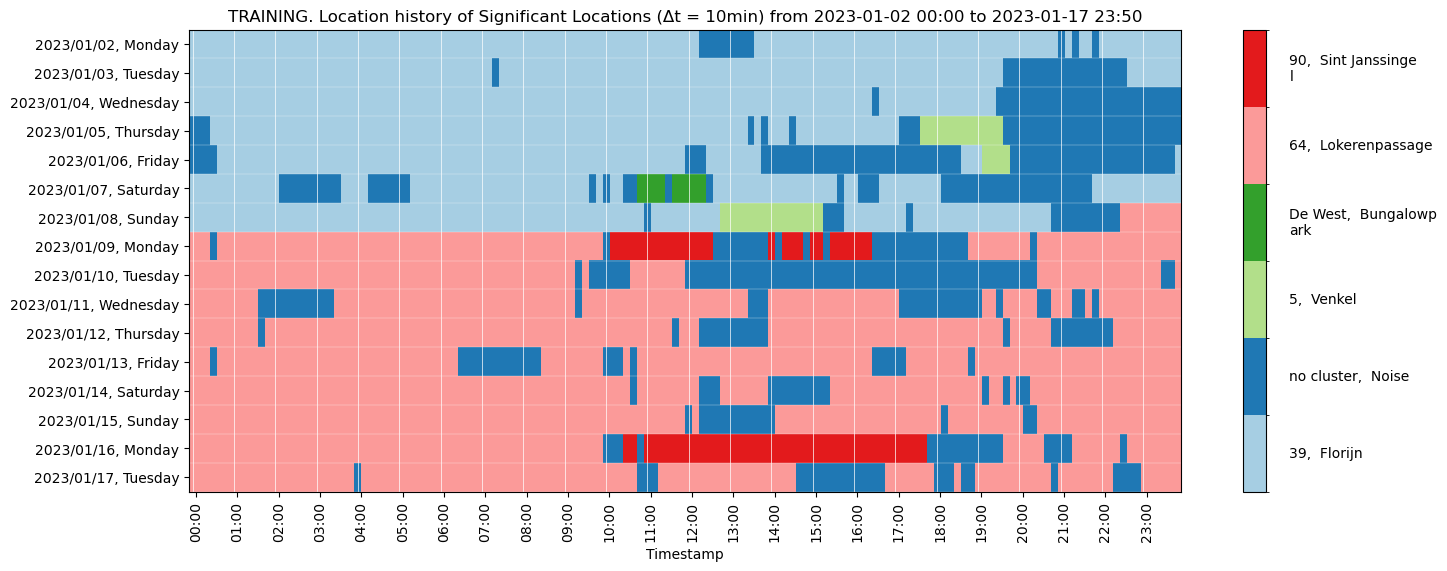

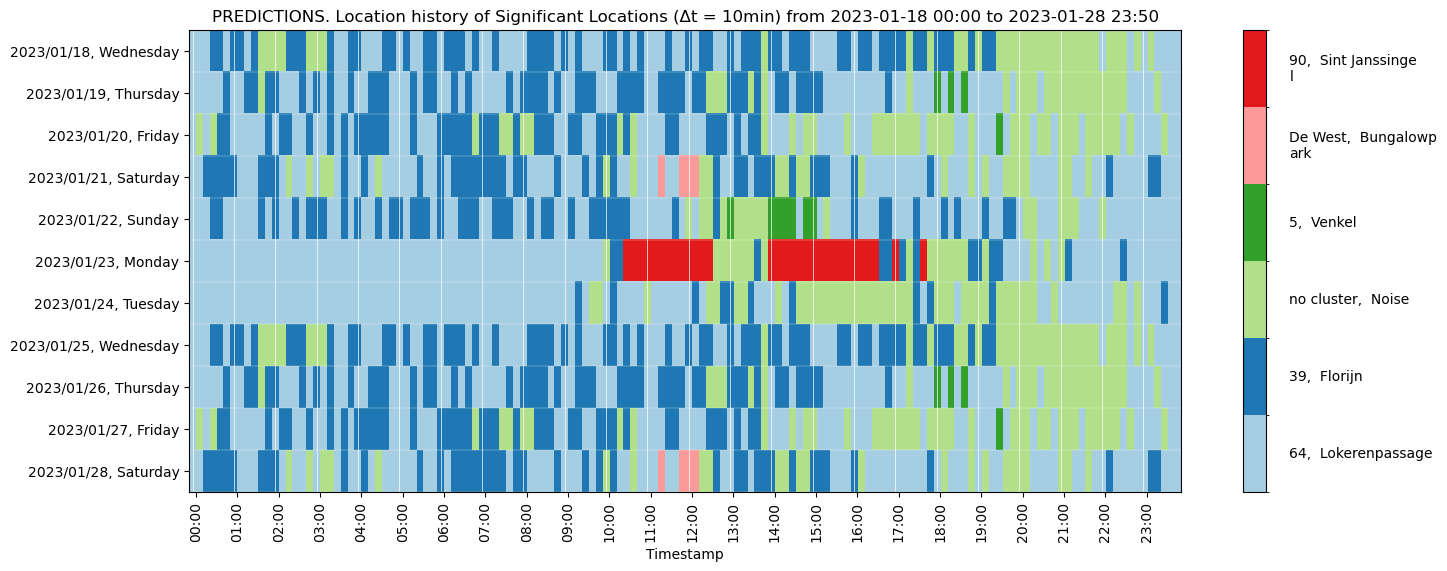

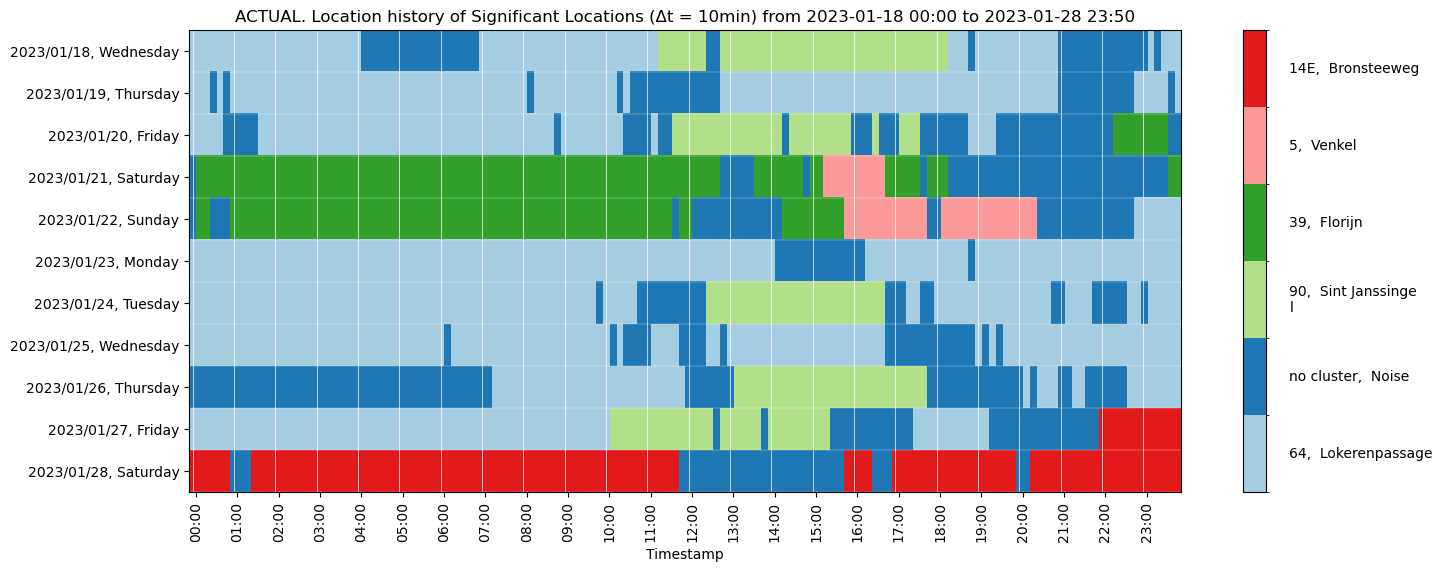

In [45]:
df.location = label_encoder.inverse_transform(df.location)

time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "timestamp": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "timestamp"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_training",
    title="TRAINING",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    name="heatmap_predicted",
    title="PREDICTIONS",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "timestamp"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_actual",
    title="ACTUAL",
)

In [3]:
test_start_date = pd.to_datetime("2023-01-01 00:00")
test_end_date = pd.to_datetime("2023-01-05 23:50")

time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "timestamp": time_intervals
    }
)

In [5]:
df_predictions

,timestamp
0,2023-01-01 00:00:00
1,2023-01-01 00:10:00
2,2023-01-01 00:20:00
3,2023-01-01 00:30:00
4,2023-01-01 00:40:00
...,...
715,2023-01-05 23:10:00
716,2023-01-05 23:20:00
717,2023-01-05 23:30:00
718,2023-01-05 23:40:00


In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

In [ ]:
print(f"Acc random forest classifier: {accuracy_score(y_test, predictions)}")
print(f"Acc dummy model: {accuracy_score(y_test, dummy_predictions)}")

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, dummy_predictions, labels=dummy_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_model.classes_)
disp.plot()
plt.show()